####**Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install -r /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/Crop-Yield-ML/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.7 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/requirements.txt (line 141))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [3]:
!pip install plotly-geo shapely==1.8.5 kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.4
    Uninstalling shapely-2.0.4:
      Successfully uninstalled shapely-2.0.4


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import sys
import random
random.seed(10)
sys.path.append('/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data')
data_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/full_data.csv'
fips_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/fips2county.tsv'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/pytorch-softdtw-cuda/')
image_path = '/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/'
processed_data_path='/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/data/processed_data'
%pylab inline

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from soft_dtw_cuda import SoftDTW
from math import sqrt
import collections
import os
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#**Preprocessing**

In [2]:
# break up dataframe into a list of timeseries
def breakup_timeseries(data):
    ts = []
    data = data[(data["County"] != "OTHER COUNTIES") & (data["County"] != "OTHER (COMBINED) COUNTIES")]
    data.set_index('Year', inplace=True)
    pairs = data[['State', 'County']].drop_duplicates().values.tolist()

    for p in pairs:
        state = p[0]
        county = p[1]
        ts.append(data[(data['State'] == state) & (data['County'] == county)])
    return ts

In [3]:
# linearly interpolate missing data
def interpolate_data(data):
    series_lengths = [len(series) for series in data]
    problems_index = []
    max_len = max(series_lengths)
    longest_series = None
    for series in data:
        if len(series) == max_len:
            longest_series = series

    for i in range(len(data)):
        if len(data[i])!= max_len:
            problems_index.append(i)
            data[i] = data[i].reindex(longest_series.index)

    for i in problems_index:
        data[i].interpolate(limit_direction="both",inplace=True)

    for i in range(len(data)):
        data[i].reset_index(inplace=True)
        data[i].fillna(method='bfill', inplace=True)
        data[i].fillna(method='ffill', inplace=True)
        data[i].fillna(method='backfill', inplace=True)

    return data


In [4]:
# performs breakup and interpolation
def preprocess(data,interpolate=True):
    print('splitting data...')
    series = breakup_timeseries(data)
    if interpolate:
      print('interpolating data...')
      return interpolate_data(data=series)
    else:
      for i in range(len(series)):
        series[i].na.replace(value=0)
    return series

In [5]:
# process the data
def process_data(interpolate=True):
  data = pd.read_csv(data_path)
  processed_data = preprocess(data,interpolate)
  return processed_data

In [6]:
processed_data = process_data(interpolate=True)
# random.shuffle(processed_data)
print('number of series: ', len(processed_data))
print(processed_data[0].tail())

splitting data...
interpolating data...
number of series:  2810
    Year    State   County  CORN, GRAIN - YIELD, MEASURED IN BU / ACRE
78  2019  ALABAMA  AUTAUGA                                       165.3
79  2020  ALABAMA  AUTAUGA                                       156.6
80  2021  ALABAMA  AUTAUGA                                       156.6
81  2022  ALABAMA  AUTAUGA                                       156.6
82  2023  ALABAMA  AUTAUGA                                       156.6


In [7]:
# map counties to their corresponding timeseries
mapping = {}
test_ind = 0
for df in processed_data:
  pair = df[["State", "County"]].drop_duplicates().values.tolist()[0]
  if test_ind == 0:
    print(pair)
  value = df[["CORN, GRAIN - YIELD, MEASURED IN BU / ACRE"]].values
  mapping[(pair[0], pair[1])] = value.reshape(value.shape[0],)
  test_ind+=1

# convert to tensor
tensor_array = torch.tensor([mapping[key] for key in mapping.keys()])
print(tensor_array.shape)

['ALABAMA', 'AUTAUGA']
torch.Size([2810, 83])


#**Building Model**

In [2]:
"""
Much of this code is modified from:
- https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/
"""

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

# SOM class
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, niter, alpha=None, sigma=None, loss='dtw'):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.zeros(m*n, dim)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))

        # euclidean distance
        self.pdist = nn.PairwiseDistance(p=2)
        # DTW
        self.sdtw = SoftDTW(use_cuda=True,gamma=0.1)
        self.loss = loss

    # return neuron weights
    def get_weights(self):
        return self.weights

    # return neuron locations
    def get_locations(self):
        return self.locations

    # calculate neuron locations
    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    # creates the graph for the SOM
    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self.weights.cpu()))],
                            key=lambda x: np.linalg.norm(vect-self.weights[x].cpu()))
            to_return.append(self.locations[min_index].cpu())

        return to_return

    # forward pass of a single timeseries input
    def forward(self, x, it):
      # use DTW instead of euclidean distance
        if self.loss == "dtw":
          inp_tensors = torch.stack([x for i in range(self.m*self.n)]).unsqueeze(2).cuda()
          weights = self.weights.unsqueeze(2).cuda()
          dists = self.sdtw(inp_tensors, weights)
        else:
          inp_tensors = torch.stack([x for i in range(self.m*self.n)]).cuda()
          weights = self.weights.cuda()
          dists = self.pdist(inp_tensors, weights)

        # get the best matching unit
        _, bmu_index = torch.min(dists, 0)
        bmu_loc = self.locations[bmu_index,:]
        bmu_loc = bmu_loc.squeeze()

        learning_rate_op = 1.0 - it/self.niter
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        bmu_distance_squares = torch.sum(torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.m*self.n)]).float(), 2), 1)

        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))
        # linearly decreasing learning rate
        learning_rate_op = alpha_op * neighbourhood_func
        
        # update weights 
        if self.loss == "dtw":
          learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)]).unsqueeze(2).cuda()

          delta = torch.mul(learning_rate_multiplier, (inp_tensors - weights))
          weights = torch.add(weights, delta)
          self.weights = weights.squeeze(2)
        else:
          learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)]).cuda()

          delta = torch.mul(learning_rate_multiplier, (inp_tensors - weights))
          weights = torch.add(weights, delta)
          self.weights = weights

#**Training function**

In [33]:
# training function
def train_som(m, n, iters, loss, use_cuda = False, tol=0.01, patience=10,early_stop=True):
  """
  Much of the code is modified from: https://github.com/giannisnik/som
  """
  import numpy as np
  import torch
  from torch.autograd import Variable
  import matplotlib.pyplot as plt

  # convert data to a usable type
  data = list()
  keys = list(mapping.keys())

  for key in keys:
      data.append(torch.FloatTensor(mapping[key]))

  # 83 is the known length of our timeseries
  som = SOM(m, n, 83, iters, loss=loss).cuda()
  print("Beginning training...")
  curr_misses = 0

  # we know the lowest possible silhouette score is -1, so -2 is our start
  last_score = -2.0

  for iter_no in range(iters):

    #Train with each time series one by one
    for i in range(len(data)):
      input = data[i].cuda()
      som(input, iter_no)

    # get the win map and calculate silhouette score
    mapped = som.map_vects(data)
    print(f'iteration {iter_no+1} complete.')
    score = compute_silhoutte(mapped,data,m,n)
    print("Silhouette: ", score)

    # early stopping conditions
    if early_stop:
      diff = score - last_score
      print("Diff: ", diff)
      if diff < tol:
        curr_misses += 1
      else:
        last_score = score
        curr_misses = 0
      if curr_misses >= patience:
        print(f"EARLY STOPPING EXECUTED. Iterations: {iter_no}")
        break

  print('Finished training')

  #Store a centroid grid for easy retrieval later on
  centroid_grid = [[] for i in range(m)]
  weights = som.get_weights()
  locations = som.get_locations()
  for i, loc in enumerate(locations):
      centroid_grid[loc[0].cpu()].append(weights[i].cpu().numpy())

  #Get output grid
  image_grid = centroid_grid
  
  #Map colours to their closest neurons
  mapped = som.map_vects(data)

  return mapped, data

#**Plotting Functions**

In [10]:
# function to help create the .gif
def helper(path, n):
  return [imageio.imread(path) for i in range(n)]

In [11]:
import imageio
# creates a .gif of the training process
def animate(name,iters):
  paths = [image_path+f"{name}_{iter}.png" for iter in iters]
  ims = []
  for f in paths:
    ims += helper(f, 3)

  imageio.mimwrite(image_path+f"{name}_animated.gif", ims)

In [45]:
import plotly.figure_factory as ff
import plotly.io as pio

# creates the map plot
def plot_map(data, name, iter):

    # get the fips codes for each county
    state_county_fips = pd.read_csv(fips_path, sep="\t")
    state_names = state_county_fips["StateName"].tolist()
    county_names = state_county_fips["CountyName"].tolist()
    fips = state_county_fips["CountyFIPS"].tolist()

    state_names = [name.upper() for name in state_names]
    county_names = [name.upper() for name in county_names]

    keys = zip(state_names, county_names)
    county_fips = dict(zip(keys, fips))

    labels = []
    values = []

    # get our data in plot format
    for state in data.keys():
        for county in data[state]:
            for pair in county_fips.keys():
                if state in pair[0] and county in pair[1]:
                    labels.append(str(county_fips[pair]))
                    values.append(int(data[state][county]))

    # chloropleth plot
    fig = ff.create_choropleth(
        fips=labels, values=values, scope=["IL", "IA", "MN", "MO", "NE", "ND", "SD", "WI"],
        county_outline={'color': 'rgb(0,0,0)', 'width': 0.5},
        state_outline={'color': 'rgb(0,0,0)', 'width': 1.0}, round_legend_values=True,
        legend_title='Cluster', title='Midwest Clustered by Yield'
    )
    print(f"Saved plot to {image_path}{name}_{iter}.png")
    pio.write_image(fig, image_path+f"{name}_{iter}.png")
    fig.show()


In [13]:
def plot(data,name, iters):
  for iter in range(1,iters+1):
    plot_map(data, name, iter)
    print(f'plotted image {iter}')
  animate(name, iters)

In [14]:
# create a numeric encoding for each cluster
def encode_clusters(m,n):
  mapping = {}
  cluster = 1
  for i in range(m):
    for j in range(n):
      arr = tuple([i,j])
      mapping[arr] = cluster
      cluster += 1
  print(mapping)
  return mapping

In [15]:
# get clusters from the SOM mapping
def get_clusters(som_map, keys, m, n):
  clusters = encode_clusters(m,n)
  cluster_map = collections.defaultdict(dict)
  print(cluster_map)
  cluster = 1
  for i in range(len(keys)):
    state = keys[i][0]
    county = keys[i][1]
    try:

      arr = tuple(som_map[i].cpu().detach().numpy())
    except:
      arr = tuple(som_map[i].numpy())
    cluster_map[state][county] = clusters[arr]
  return cluster_map

In [16]:
# plots a heatmap of the latent space (NOT USED)
def plot_som_grid(som_map, n, m, bin_length):

  grid_size = bin_length
  x_range = (0, n)
  y_range = (0, m)

  # Create 2D histogram to count points in each grid square
  hist, x_edges, y_edges = np.histogram2d([point[0] for point in som_map],
                                          [point[1] for point in som_map],
                                          bins=grid_size,
                                          range=[x_range, y_range])

  # Plot heatmap
  plt.imshow(hist.T, origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
  plt.colorbar(label='Number of Members')

  # Add labels and title
  plt.xlabel('m')
  plt.ylabel('n')
  plt.title('Heatmap of Latent Space')

  # Show plot
  plt.grid(True)
  plt.show()



#**Method 1:**
Training an mxn SOM and use the 2-d map locations as their own clusters.

In [32]:
# animate the training process for a SOM
def som_animation(m,n,iters,loss,name,early_stop=True):
  keys = list(mapping.keys())
  iters = range(1,iters+1)
  final_som_map = None
  data = None
  for i in iters:
    print('===============================')
    som_map,data = train_som(m=m,n=n,iters=i,loss=loss,early_stop=early_stop)
    print("-------------------------------")
    clusters = get_clusters(som_map,keys,m=m,n=n)
    plot_map(clusters,name=name,iter=i)
    final_som_map = som_map
  animate(name,iters)
  return som_map,data

In [18]:
# turn our data into numpy arrays for silhouette calculation
def convert_map_to_labels(som_map,m,n):
  output = []
  mapping = {}

  som_list = [tuple(i.numpy()) for i in som_map]
  count = 0
  for i in range(m):
    for j in range(n):
      if (i,j) not in mapping:
        mapping[(i,j)] = count
        count += 1
  for i in som_list:
    output.append(mapping[i])
  return np.array(output)

In [19]:
from sklearn.metrics import silhouette_score
# calculate the silhouette score
def compute_silhoutte(mapping,data,m,n):
  numpy_data = [tensor.numpy() for tensor in data]
  labels = convert_map_to_labels(mapping, m, n)
  return silhouette_score(numpy_data, labels)

#### DTW - 16 clusters

In [20]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=4,n=4,iters=5000,loss="dtw")
clusters = get_clusters(som_map,keys,m=4,n=4)
plot_map(clusters,name="DTW_16CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,4,4)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.063226774
Diff:  2.0632267743349075
iteration 2 complete.
Silhouette:  0.06296478
Diff:  -0.00026199222
iteration 3 complete.
Silhouette:  0.062657006
Diff:  -0.00056976825
iteration 4 complete.
Silhouette:  0.0626743
Diff:  -0.00055247545
iteration 5 complete.
Silhouette:  0.062906526
Diff:  -0.0003202483
iteration 6 complete.
Silhouette:  0.06233811
Diff:  -0.0008886643
iteration 7 complete.
Silhouette:  0.06233811
Diff:  -0.0008886643
iteration 8 complete.
Silhouette:  0.062385347
Diff:  -0.0008414276
iteration 9 complete.
Silhouette:  0.062385347
Diff:  -0.0008414276
iteration 10 complete.
Silhouette:  0.06248007
Diff:  -0.00074670464
iteration 11 complete.
Silhouette:  0.06248007
Diff:  -0.00074670464
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (0, 1): 2, (0, 2): 3, (0, 3): 4, (1, 0): 5, (1, 1): 6, (1, 2): 7, (1, 3): 8, (2, 0): 9, (2, 1): 10, (2, 2): 11, (2, 3): 12, (3, 0): 13, (3, 1): 14, (3, 2):

#### DTW - 3 clusters

In [46]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=3,n=1,iters=5000,loss="dtw")
clusters = get_clusters(som_map,keys,m=3,n=1)
plot_map(clusters,name="DTW_3CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,3,1)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.21880838
Diff:  2.2188083827495575
iteration 2 complete.
Silhouette:  0.21880838
Diff:  0.0
iteration 3 complete.
Silhouette:  0.21891859
Diff:  0.00011020899
iteration 4 complete.
Silhouette:  0.21912023
Diff:  0.0003118515
iteration 5 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 6 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 7 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 8 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 9 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 10 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
iteration 11 complete.
Silhouette:  0.21950142
Diff:  0.0006930381
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (1, 0): 2, (2, 0): 3}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/DTW_3CLUSTERS5Iters_5.png


0.21950142


#### DTW - 5 clusters

In [51]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=5,n=1,iters=5000,loss="dtw")
clusters = get_clusters(som_map,keys,m=5,n=1)
plot_map(clusters,name="DTW_5CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,5,1)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.119110234
Diff:  2.119110234081745
iteration 2 complete.
Silhouette:  0.119110234
Diff:  0.0
iteration 3 complete.
Silhouette:  0.119110234
Diff:  0.0
iteration 4 complete.
Silhouette:  0.11906201
Diff:  -4.822761e-05
iteration 5 complete.
Silhouette:  0.11906201
Diff:  -4.822761e-05
iteration 6 complete.
Silhouette:  0.11906201
Diff:  -4.822761e-05
iteration 7 complete.
Silhouette:  0.11895406
Diff:  -0.00015617162
iteration 8 complete.
Silhouette:  0.11909522
Diff:  -1.501292e-05
iteration 9 complete.
Silhouette:  0.11904414
Diff:  -6.60941e-05
iteration 10 complete.
Silhouette:  0.11904414
Diff:  -6.60941e-05
iteration 11 complete.
Silhouette:  0.119012035
Diff:  -9.819865e-05
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (1, 0): 2, (2, 0): 3, (3, 0): 4, (4, 0): 5}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/DTW_5CLUST

0.119012035


#### DTW - 4 clusters

In [50]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=2,n=2,iters=5000,loss="dtw")
clusters = get_clusters(som_map,keys,m=2,n=2)
plot_map(clusters,name="DTW_4CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,2,2)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.15721013
Diff:  2.157210126519203
iteration 2 complete.
Silhouette:  0.15719587
Diff:  -1.4260411e-05
iteration 3 complete.
Silhouette:  0.15719587
Diff:  -1.4260411e-05
iteration 4 complete.
Silhouette:  0.15735824
Diff:  0.00014811754
iteration 5 complete.
Silhouette:  0.15715617
Diff:  -5.3957105e-05
iteration 6 complete.
Silhouette:  0.15719062
Diff:  -1.950562e-05
iteration 7 complete.
Silhouette:  0.15719101
Diff:  -1.911819e-05
iteration 8 complete.
Silhouette:  0.1572134
Diff:  3.2782555e-06
iteration 9 complete.
Silhouette:  0.15719382
Diff:  -1.630187e-05
iteration 10 complete.
Silhouette:  0.15723659
Diff:  2.6464462e-05
iteration 11 complete.
Silhouette:  0.15723659
Diff:  2.6464462e-05
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/DT

0.15723659


#### EUC - 3 clusters

In [47]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=3,n=1,iters=5000,loss="euc")
clusters = get_clusters(som_map,keys,m=3,n=1)
plot_map(clusters,name="EUC_3CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,3,1)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.2193716
Diff:  2.2193716019392014
iteration 2 complete.
Silhouette:  0.2193716
Diff:  0.0
iteration 3 complete.
Silhouette:  0.2195239
Diff:  0.00015230477
iteration 4 complete.
Silhouette:  0.2195239
Diff:  0.00015230477
iteration 5 complete.
Silhouette:  0.2195239
Diff:  0.00015230477
iteration 6 complete.
Silhouette:  0.2195239
Diff:  0.00015230477
iteration 7 complete.
Silhouette:  0.2195239
Diff:  0.00015230477
iteration 8 complete.
Silhouette:  0.21999443
Diff:  0.00062282383
iteration 9 complete.
Silhouette:  0.22015214
Diff:  0.0007805377
iteration 10 complete.
Silhouette:  0.22015214
Diff:  0.0007805377
iteration 11 complete.
Silhouette:  0.22016723
Diff:  0.0007956326
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (1, 0): 2, (2, 0): 3}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/EUC_3CLUSTERS5Iters_5.png


0.22016723


#### EUC - 4 clusters

In [49]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=2,n=2,iters=5000,loss="euc")
clusters = get_clusters(som_map,keys,m=2,n=2)
plot_map(clusters,name="EUC_4CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,2,2)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.15687858
Diff:  2.15687857568264
iteration 2 complete.
Silhouette:  0.15687858
Diff:  0.0
iteration 3 complete.
Silhouette:  0.15692364
Diff:  4.506111e-05
iteration 4 complete.
Silhouette:  0.1571682
Diff:  0.00028961897
iteration 5 complete.
Silhouette:  0.15716706
Diff:  0.00028848648
iteration 6 complete.
Silhouette:  0.15720192
Diff:  0.0003233403
iteration 7 complete.
Silhouette:  0.15716882
Diff:  0.00029024482
iteration 8 complete.
Silhouette:  0.15719382
Diff:  0.00031524897
iteration 9 complete.
Silhouette:  0.15716997
Diff:  0.0002913922
iteration 10 complete.
Silhouette:  0.15716997
Diff:  0.0002913922
iteration 11 complete.
Silhouette:  0.1571577
Diff:  0.00027912855
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/EUC_4CLUSTERS5Iters_5

0.1571577


#### EUC - 5 clusters

In [48]:
keys = list(mapping.keys())
final_som_map = None
data = None
som_map,data = train_som(m=5,n=1,iters=5000,loss="euc")
clusters = get_clusters(som_map,keys,m=5,n=1)
plot_map(clusters,name="EUC_5CLUSTERS5Iters",iter=5)
score = compute_silhoutte(som_map,data,5,1)
print(score)

Beginning training...
iteration 1 complete.
Silhouette:  0.119110234
Diff:  2.119110234081745
iteration 2 complete.
Silhouette:  0.119110234
Diff:  0.0
iteration 3 complete.
Silhouette:  0.119110234
Diff:  0.0
iteration 4 complete.
Silhouette:  0.11906201
Diff:  -4.822761e-05
iteration 5 complete.
Silhouette:  0.11906201
Diff:  -4.822761e-05
iteration 6 complete.
Silhouette:  0.11895406
Diff:  -0.00015617162
iteration 7 complete.
Silhouette:  0.11908663
Diff:  -2.360344e-05
iteration 8 complete.
Silhouette:  0.11903554
Diff:  -7.469207e-05
iteration 9 complete.
Silhouette:  0.11903554
Diff:  -7.469207e-05
iteration 10 complete.
Silhouette:  0.11900347
Diff:  -0.00010676682
iteration 11 complete.
Silhouette:  0.11900347
Diff:  -0.00010676682
EARLY STOPPING EXECUTED. Iterations: 10
Finished training
{(0, 0): 1, (1, 0): 2, (2, 0): 3, (3, 0): 4, (4, 0): 5}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/EUC_5CL

0.11900347


#### Animation

In [34]:
som_map,data = som_animation(m=2,n=2,iters=25,loss="dtw",name="DTW_4_animation_clusters_50iters",early_stop=False)
score = compute_silhoutte(som_map,data,2,2)
print("silhoutte score: ", score)

Beginning training...
iteration 1 complete.
Silhouette:  0.15721013
Finished training
-------------------------------
{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/DTW_4_animation_clusters_50iters_1.png
Beginning training...
iteration 1 complete.
Silhouette:  0.15721013
iteration 2 complete.
Silhouette:  0.19110744
Finished training
-------------------------------
{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
defaultdict(<class 'dict'>, {})
Saved plot to /content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Crop-Yield-ML/images/DTW_4_animation_clusters_50iters_2.png
Beginning training...
iteration 1 complete.
Silhouette:  0.15721013
iteration 2 complete.
Silhouette:  0.21839745
iteration 3 complete.
Silhouette:  0.19053097
Finished training
-------------------------------
{(0, 0): 1, (0, 1): 2, (1, 0): 3, (1, 1): 4}
defaultdict(<class 'dict'>, {})
Saved p

#### Graphing clusters vs silhouette score

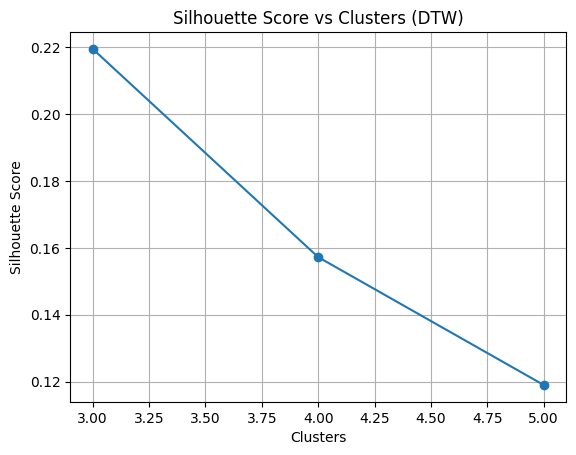

In [37]:

x = [3, 4, 5]
y = [0.21950142, 0.15723659, 0.119012035]

plt.plot(x, y, marker='o', linestyle='-')

plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Clusters (DTW)')

plt.grid(True)
plt.show()

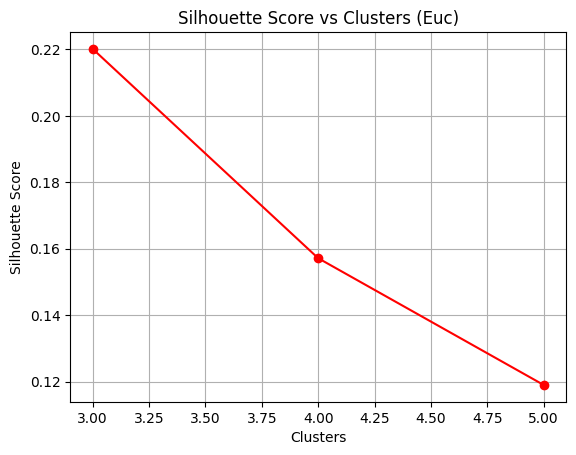

In [44]:
x = [3, 4, 5]
y2 = [0.22016723, 0.1571577, 0.11900347]

plt.plot(x, y2, marker='o', linestyle='-', color="red")

plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Clusters (Euc)')

plt.grid(True)
plt.show()